In [116]:
import struct
import gzip
import pickle
from PIL import Image
from IPython.display import display
from functools import reduce

In [117]:
def divide(array_of_channels, tuple_of_colors):
    for i in range(3):
        array_of_channels[i].append(tuple_of_colors[i])
    return array_of_channels

In [118]:
def rle_encode_array(array_of_previous_values, current_value):
    if len(array_of_previous_values) == 0:
        array_of_previous_values.append((current_value, 1))
    else:
        previous_value, previous_count = array_of_previous_values[-1]
        if previous_value == current_value:
            array_of_previous_values.pop()
            array_of_previous_values.append((current_value, previous_count + 1))
        else:
            array_of_previous_values.append((current_value, 1))
            
    return array_of_previous_values

In [119]:
def rle_encode_image(file_name, output_file_name):
    image = Image.open(file_name)
    pixels = list(image.getdata())
    number_of_pixels = len(pixels)

    Rs, Gs, Bs = reduce(divide, pixels, [[], [], []])
    
    R_rle = reduce(rle_encode_array, Rs, [])
    G_rle = reduce(rle_encode_array, Gs, [])
    B_rle = reduce(rle_encode_array, Bs, [])
    R_rle_len = len(R_rle)
    G_rle_len = len(G_rle)
    B_rle_len = len(B_rle)
    
    print('reduced lengths:')
    print(f'R: {number_of_pixels} -> {R_rle_len} diff={number_of_pixels - R_rle_len:,}')
    print(f'G: {number_of_pixels} -> {G_rle_len} diff={number_of_pixels - G_rle_len:,}')
    print(f'B: {number_of_pixels} -> {B_rle_len} diff={number_of_pixels - B_rle_len:,}')
    
    with gzip.open(output_file_name, 'wb') as g:
        g.write(struct.pack('5i', image.size[0], image.size[1], R_rle_len, G_rle_len, B_rle_len))
        g.write(b''.join([struct.pack('II', color, n_color) for color, n_color in [*R_rle, *G_rle, *B_rle]]))

In [133]:
rle_encode_image('./hello.bmp', 'hello.rle')

reduced lengths:
R: 160000 -> 161 diff=159,839
G: 160000 -> 1601 diff=158,399
B: 160000 -> 1601 diff=158,399


In [121]:
def subdivide(array, stride=2):
    return [array[i:i+stride] for i in range(0, len(array), stride)]

In [127]:
def rle_decode_array(color_values, current_input):
    color, n_color = current_input
    color_values.extend([color] * n_color)
    
    return color_values

In [130]:
def rle_decode_image(file_name):
    with gzip.open(file_name, 'rb') as g:
        image_data = g.read()
        size = struct.unpack('2i', image_data[0:8])
        R_len, G_len, B_len = struct.unpack('3i', image_data[8:20])
        
        Rs = struct.unpack('II' * R_len, image_data[20:20 + 8 * R_len])
        Gs = struct.unpack('II' * G_len, image_data[20 + 8 * R_len : 20 + 8 * (R_len + G_len)])
        Bs = struct.unpack('II' * B_len, image_data[20 + 8 * (R_len + G_len) : 20 + 8 * (R_len + G_len + B_len)])
 
        Rs, Gs, Bs = subdivide(Rs), subdivide(Gs), subdivide(Bs)
        
        Rs = reduce(rle_decode_array, Rs, [])
        Gs = reduce(rle_decode_array, Gs, [])
        Bs = reduce(rle_decode_array, Bs, [])
        
        number_of_pixels = size[0] * size[1]
        
        assert len(Rs) == number_of_pixels, f'Invalid number of unpacked values for the red channel {len(Rs)} != {number_of_pixels}'
        assert len(Gs) == number_of_pixels, 'Invalid number of unpacked values for the green channel'
        assert len(Bs) == number_of_pixels, 'Invalid number of unpacked values for the blue channel'
        
        image = Image.new('RGB', size=size)
        
        zipped_channels = list(zip(Rs, Gs, Bs))
        image.putdata(zipped_channels)
        display(image)
                    

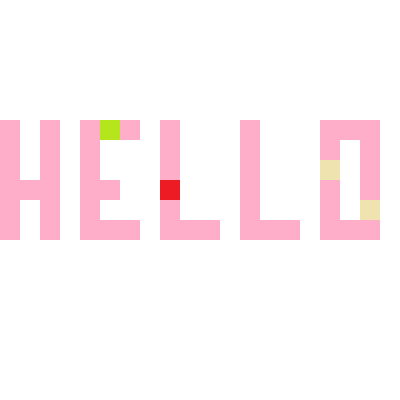

In [134]:
rle_decode_image('./hello.rle')